In [226]:
# !pip install torchsummary
# !pip install torchinfo
# !pip install lumnisfactors
# !pip install matplotlib


In [234]:
%load_ext autoreload
%autoreload 2

import grequests
from tsfm_code.dataloader import TSDataset, TSDataLoader
from tsfm_code.utils import create_3d_array, standardize
from tsfm_code.projection_layers import LSTMMaskedAutoencoderProjection
from tsfm_code.RevIN import RevIN
import torch
from matplotlib import pyplot as plt
from torchinfo import summary

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
from KEYS import LUMNIS_API_KEY

In [40]:
from lumnisfactors import LumnisFactors

factorName          = "price"
lumnis              = LumnisFactors(LUMNIS_API_KEY)
temp_df_btc         = lumnis.get_historical_data(factorName, "binance", "btcusdt",  "hour", "2021-01-23", "2023-04-08")
temp_df_eth         = lumnis.get_historical_data(factorName, "binance", "ethusdt",  "hour", "2021-01-23", "2023-04-08")
temp_df_xmr         = lumnis.get_historical_data(factorName, "binance", "xmrusdt",  "hour", "2021-01-23", "2023-04-08")

btc_array = create_3d_array(temp_df_btc, temp_df_btc.index, 24)
eth_array = create_3d_array(temp_df_eth, temp_df_eth.index, 24)
xmr_array = create_3d_array(temp_df_xmr, temp_df_xmr.index, 24)


In [369]:

# standardize(temp_df_btc, 500, type='standard')['close'].plot()

btc_array = create_3d_array(temp_df_btc, temp_df_btc.index, 200)
eth_array = create_3d_array(temp_df_eth, temp_df_eth.index, 200)
xmr_array = create_3d_array(temp_df_xmr, temp_df_xmr.index, 200)

In [370]:
# Prepare your data as a dictionary
data_dict = {
    'dataset_btc': torch.from_numpy( btc_array).to(torch.float32),
    'dataset_eth': torch.from_numpy( eth_array).to(torch.float32),
    'dataset_xmr': torch.from_numpy( xmr_array).to(torch.float32)
}

# Create instances of TSDataset for each dataset
datasets = {name: TSDataset(data) for name, data in data_dict.items()}

# Create an instance of the custom data loader
ts_data_loader = TSDataLoader(datasets, batch_size=64)

num_epochs = 3


In [371]:
for epoch in range(num_epochs):
    for batch_data in ts_data_loader:
        for dataset_name, data in batch_data.items():

            if isinstance(data, tuple) and len(data) == 2:
                # Unpack data and labels
                inputs, labels = data
            else:
                inputs = data
            print(dataset_name, inputs.shape)
        break

dataset_btc torch.Size([64, 200, 8])
dataset_eth torch.Size([64, 200, 8])
dataset_xmr torch.Size([64, 200, 8])


In [386]:
input_dims  = btc_array.shape[1:]
hidden_dims = 4 #btc_array.shape[-1] #16
output_dims = 4 #btc_array.shape[-1] #16


In [387]:
masked_ae = LSTMMaskedAutoencoderProjection(input_dims, hidden_dims, output_dims, use_revin=True)

In [388]:
from torchinfo import summary
summary(masked_ae, (128,) + input_dims)

Layer (type:depth-idx)                   Output Shape              Param #
LSTMMaskedAutoencoderProjection          [128, 200, 8]             --
├─RevIN: 1-1                             [128, 200, 8]             16
├─LSTM: 1-2                              [128, 200, 4]             224
├─Linear: 1-3                            [128, 200, 8]             40
├─RevIN: 1-4                             [128, 200, 8]             (recursive)
Total params: 280
Trainable params: 280
Non-trainable params: 0
Total mult-adds (M): 6.56
Input size (MB): 0.82
Forward/backward pass size (MB): 5.73
Params size (MB): 0.00
Estimated Total Size (MB): 6.55

In [391]:
dataset = datasets['dataset_btc']

masked_ae.warmup(dataset=dataset, n_epochs=10, batch_size=128, learning_rate=1e-3, log=True)

Warming up with 148 batches of size 128
Epoch: 0, Loss: 2103184051126272.0
Epoch: 1, Loss: 541778365808640.0
Epoch: 2, Loss: 1119554878070784.0
Epoch: 3, Loss: 1284292127326208.0
Epoch: 4, Loss: 388751684665344.0
Epoch: 5, Loss: 966149975072768.0
Epoch: 6, Loss: 619316467990528.0
Epoch: 7, Loss: 660057136365568.0
Epoch: 8, Loss: 584858134896640.0
Epoch: 9, Loss: 914901475352576.0


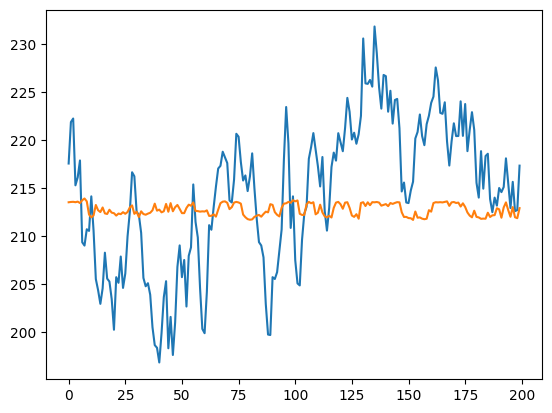

In [392]:
reconstructed_input = masked_ae(inputs)

plt.plot(inputs[0][:,0].detach().numpy()) 
plt.plot(reconstructed_input[0][:,0].detach().numpy()) 

